# Land-use Map and Demand

## Land-use Map of Australia in 2010

LUTO-2 uses the national land-use map of 2010 as the starting point. The map is downloaded from [DAFF](https://www.agriculture.gov.au/abares/aclump/land-use/land-use-mapping) and has several different classification schemes. Because LUTO-2 is an agricultural model, we exclude water and intensive uses (urban built-ups, commercial uses, etc.) from the modeling and created a land-use classification based on the 'PRIMARY_V7' schema of DAFF and a profit map provided by CSIRO. The final land-use map is classified as shown in the below table.

| Code | Description                | Code | Description              | Code | Description                  | Code | Description                 |
|------|----------------------------|------|--------------------------|------|------------------------------|------|-----------------------------|
| -1   | Non Agricultural and       | 7    | Grapes                   | 15   | Sheep - natural land         | 23   | Unallocated - natural land  |
| 0    | Apples                     | 8    | Hay                      | 16   | Stone fruit                  | 24   | Vegetables                  |
| 1    | Beef - modified land       | 9    | Nuts                     | 17   | Sugar                        | 25   | Winter cereals              |
| 2    | Beef - natural land        | 10   | Other non-cereal crops   | 18   | Summer cereals               | 26   | Winter legumes              |
| 3    | Citrus                     | 11   | Pears                    | 19   | Summer legumes               | 27   | Winter oilseeds             |
| 4    | Cotton                     | 12   | Plantation fruit         | 20   | Summer oilseeds              |                                    |
| 5    | Dairy - modified land      | 13   | Rice                     | 21   | Tropical stone fruit         |                                    |
| 6    | Dairy - natural land       | 14   | Sheep - modified land    | 22   | Unallocated - modified land  |                                    |



It is overwhelming to consider all 28 agricultural land-use for illustration. Instead, let's only map the sptail distribution of `Winter cereals` under minimized-cost/maximized-profit drives given various constraints. Referring to table above, we know that the code of 25 is winter cereal. We will use this value to extract the map of winter cereal.

In [2]:
# REMOVE

# Define year, lu_code
year_begin = 2010
year_target = 2050
lu_code = 25 # Winter cereals
lu_desc = data.AGRICULTURAL_LANDUSES[lu_code]

# Parameters to save xarray
output_dir = 'luto/tools/Manual_jupyter_books/outputs'
encoding={'data': {"compression": "gzip", "compression_opts": 9,  "dtype": 'float32'}}

# Get the lumap
lumap = mrj_to_xr(data, data.ag_dvars[year_begin])

lu_arr = lumap.sel(lu=lu_desc)
lu_arr_dry = lu_arr.sel(lm='dry')
lu_arr_irr = lu_arr.sel(lm='irr')

lu_mask = arr_to_xr(data, np.ones_like(lumap)) == 1
lu_area = arr_to_xr(data, data.REAL_AREA)


# Save to disk
lu_arr_dry.name = 'data'
lu_arr_irr.name = 'data'

lu_arr_dry.to_netcdf(f'{output_dir}/lu_arr_dry.nc', engine='h5netcdf', encoding=encoding)
lu_arr_irr.to_netcdf(f'{output_dir}/lu_arr_irr.nc', engine='h5netcdf', encoding=encoding)

The same land-use under different water supply management (`dry` or `irrigated`) requires significantly different water consumption and economic investment, which ultimately leads to very different yields. To account for this, LUTO-2 introduces a dry/irrigation map that further classifies agricultural land-use into dry land or irrigated land. In this manual, we will split winter cereals into their corresponding dry and irrigated parts. Additionally, input data such as 'water requirement,' 'GHG release,' and 'cost' are provided with a water supply attribution.



If you have a pair of eagle eyes, you can find that only a very small number of irrigated winter cereal cells are scattered in Victoria.

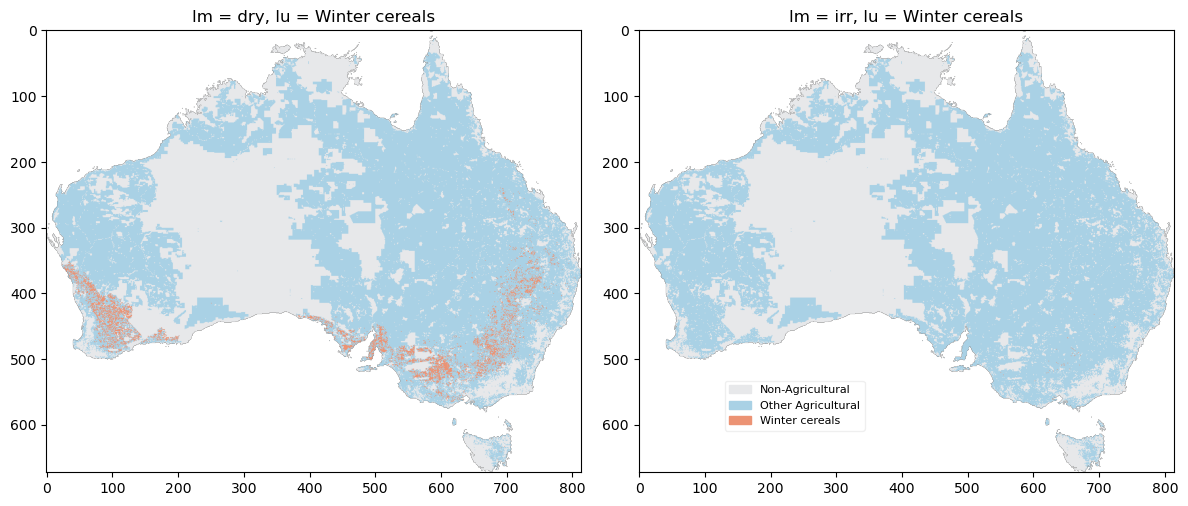

In [3]:
# HIDE CODE

# Get colors/names for pixcels with values of [-1, 0, 1]
colors = [
    (231, 232, 234, 255), # Light grey
    (169, 209, 229, 255), # Light blue
    (236, 147, 116, 255)  # Light red
]

cell_names = [
    'Non-Agricultural', 
    'Other Agricultural', 
    'Winter cereals'
]

# Create a figure and a set of subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first map (dry) on the first axis
map_to_plot(lu_arr_dry, colors, cell_names, legend_params, ax=axs[0])
axs[0].set_title(f'lm = dry, lu = {lu_desc}')

# Plot the second map (irr) on the second axis
map_to_plot(lu_arr_irr, colors, cell_names, legend_params, ax=axs[1])
axs[1].set_title(f'lm = irr, lu = {lu_desc}')

# Optionally, adjust the layout
plt.tight_layout()

# Show the combined plots
plt.show()

Before diving into input data, please keep in mind our objective: find the sptail distribution for winter cereal that is the most cost-minimized/profit-maximized, as well as meeting constraints in water use and GHG emissions.

## Commodity Demands

As an agricultural model, the first target to meet is the food demand. The demand data (tones) is a `pandas.DataFrame` lives in the `data.DEMAND_DATA` variable. We can see that the index of the demand dataframe is commodities, the column is a 2-level column that represents demand compositions and years.

```{note}
The demand includes 'DOMESTIC', 'EXPORTS', 'IMPORTS', 'FEED', 'PRODUCTION', where the 'PRODUCTION' record is the demand data that LUTO needs to meet. The relationship between these compositions is:  
`PRODUCTION` = `DOMESTIC` + `EXPORTS` + `FEED` - `IMPORTS`
```

In [4]:
# HIDE CODE
df = data.DEMAND_DATA
df_styled = df.style.set_table_styles([
    {'selector': 'td', 'props': [('font-size', '10pt')]},
    {'selector': 'th', 'props': [('font-size', '10pt')]}
]).format(precision=2)

df_styled

```{note}
If you have a close look at the `COMMODITY` index, you can find that index items are all lower-case. In addition, there are 32 commodities in total (remember there are only 28 land-uses). Why lower case and 2 more commodities? Carefully observe the table below that shows the mismatched land-use and commodities. Think of the reason by yourself; the answer is in the below explanation.
```

| Land-use                      | Comodity                          |
|-------------------------------|-----------------------------------|
| Beef - modified land          | beef lexp, beef meat              |
| Beef - natural land           | beef lexp, beef meat              |
| Dairy - modified land         | dairy                             |
| Dairy - natural land          | dairy                             |
| Unallocated - modified land   | -                                 |
| Unallocated - natural land    | -                                 |
| Sheep - modified land         | beef lexp, sheep meat, sheep wool |
| Sheep - natural land          | beef lexp, sheep meat, sheep wool |
| -                             | aquaculture                       |
| -                             | chicken                           |
| -                             | eggs                              |
| -                             | pork                              |

The design of using "lower case" for commodity names helps differentiate between "Land-use," "Product," and "Commodity." For example, land designated as "Apple" can only produce apples, whereas both "Beef - modified land" and "Beef - natural land" can produce beef for live export and beef meat. This mismatch between land types and the products they generate requires careful consideration. To address this, we use first-letter-capitalized names to indicate land-use types, all-lowercase names for products derived from the land, and all-uppercase names to refer to specific commodities.

The reason for the inclusion of "4 additional commodities" is that there are four commodities—aquaculture, chicken, eggs, and pork—that cannot be produced from any land use. While the answer is straightforward, it raises a challenge: if there are four commodities that cannot be produced by any land use, how can LUTO meet these demands through land-use distribution? LUTO addresses this by assuming that the demand for these four commodities will be met by the target year. The model then focuses on arranging land use to mitigate their environmental impacts. For instance, if meeting the demand for eggs in 2030 results in 500 kt of GHG emissions, LUTO will aim to plant more trees to sequester the carbon. By considering both on-land (commodities produced directly from land) and off-land (commodities produced from cages or factories), LUTO presents a more comprehensive agricultural model.

In this manual, we are only concerned with winter cereal produced from `Winter Cereal` land-use, which yields a single product: `winter cereal`. Therefore, we only need to examine the data.DEMAND_DATA variable to determine the future demand for this product.

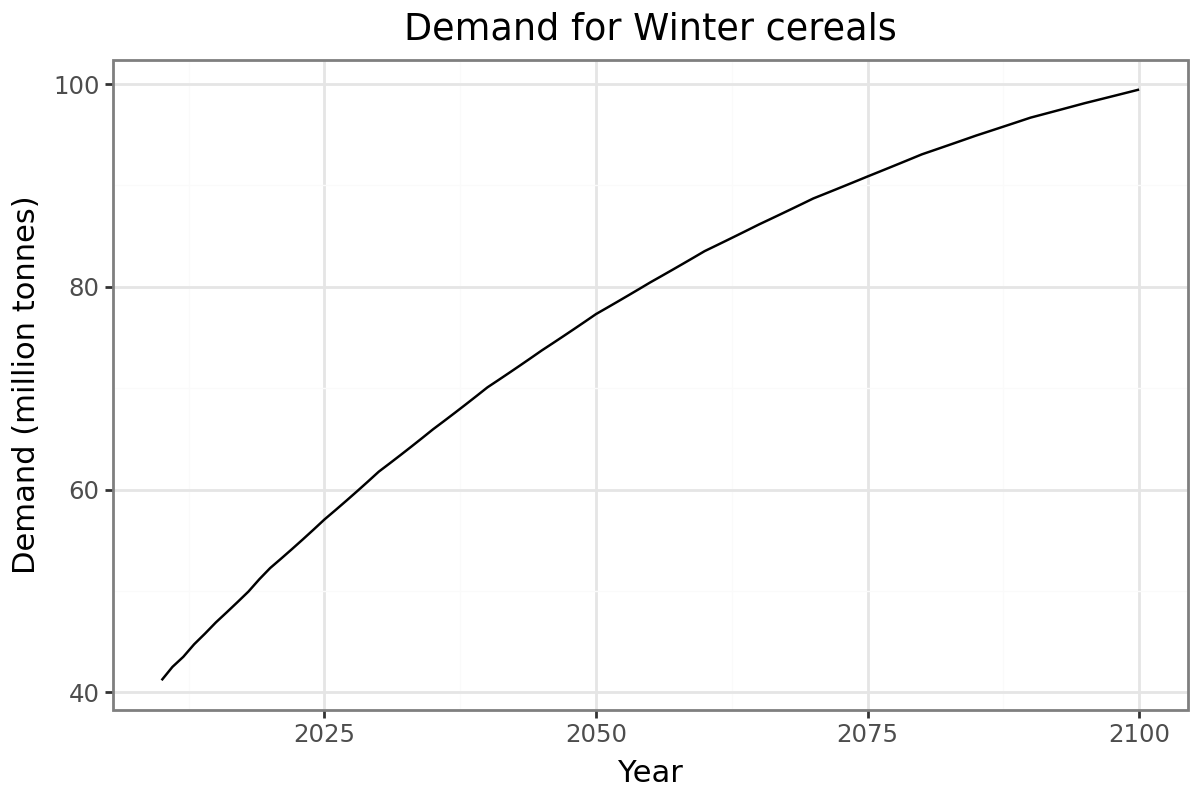

In [6]:
# HIDE CODE
p9.options.figure_size = (6, 4)
p9.options.dpi = 100

# Get the demand data
demand_df = data.DEMAND_DATA.unstack().reset_index()
demand_df.columns = ['Type', 'Year', 'Commodity', 'Value']


# Get the demand for the selected land use
demand_lu = demand_df.query('Type == "PRODUCTION" and Commodity == @lu_desc.lower()')


# Plot the demand
fig = (p9.ggplot(demand_lu, p9.aes(x='Year', y='Value'))
    + p9.geom_line()
    + p9.theme_bw()
    + p9.labs(title=f'Demand for {lu_desc}', x='Year', y='Demand (million tonnes)')
    + p9.scale_y_continuous(labels=lambda f: [f'{x / 1e6:.0f}' for x in f])
    )

fig

Let's query the demand data for year 2050 and get the target to meet.

In [6]:
# HIDE CODE
# Get the demand for the target year
demand_vol = demand_lu.query('Year == @year_target')['Value'].values[0] / 1e6  # Million tonnes

print(f'The demand for {lu_desc} in {year_target} is {demand_vol:.2f} million tonnes.')

The demand for Winter cereals in 2050 is 77.31 million tonnes.


::::{important} 
Differences in diets, exports, and economic conditions can affect food demand, so it is important to consider how these factors impact it. Fortunately, LUTO provides several options to select different scenarios based on our interests. For example, if we want to model a scenario with halved food waste, we simply need to set the `settings.WASTE` parameter to 0.5. 
::::

There are 7 parameters to determine a demand projection, we can change them to fit our anticipation of the future. We can always check the parameters used by printing out `setting.para_name`. This manual uses `SCENARIO=SSP2`, `DIET_DOM='BAU'`, `DIET_GLOB='BAU'`, `CONVERGENCE=2050`, `IMPORT_TREND='Static'`, `WASTE=1`, `FEED_EFFICIENCY='BAU'`. More choices can by found in the below table.         
 

| Parameter         | Values                          | Note                                                                                                                            |
|-------------------|---------------------------------|---------------------------------------------------------------------------------------------------------------------------------|
| SCENARIO          | SSP1, SSP2, SSP3, SSP4, SSP5    |                                                                                                                                 |
| DIET_DOM          | BAU, FLX, VEG, VGN              | 'BAU', 'FLX', 'VEG', 'VGN' - domestic diets in Australia                                                                        |
| DIET_GLOB         | BAU, FLX, VEG, VGN              | 'BAU', 'FLX', 'VEG', 'VGN' - global diets                                                                                       |
| CONVERGENCE       | 2050, 2100                      | 2050 or 2100 - date at which dietary transformation is completed (velocity of transformation)                                   |
| IMPORT_TREND      | Static, Trend                   | 'Static' assumes 2010 shares of imports for each commodity or 'Trend' follows historical rate of change in shares of imports    |
| WASTE             | 0.5, 1.0                        | 1 for full waste, 0.5 for half waste                                                                                            |
| FEED_EFFICIENCY   | BAU, High                       | 'BAU' or 'High'                                                                                                                 |



As an illustration, here is the demand for winter cereal under different domestic diets and food waste levels. It shows that socioeconomic settings have significant influences on demand, and food waste level is a much smaller impact factor.

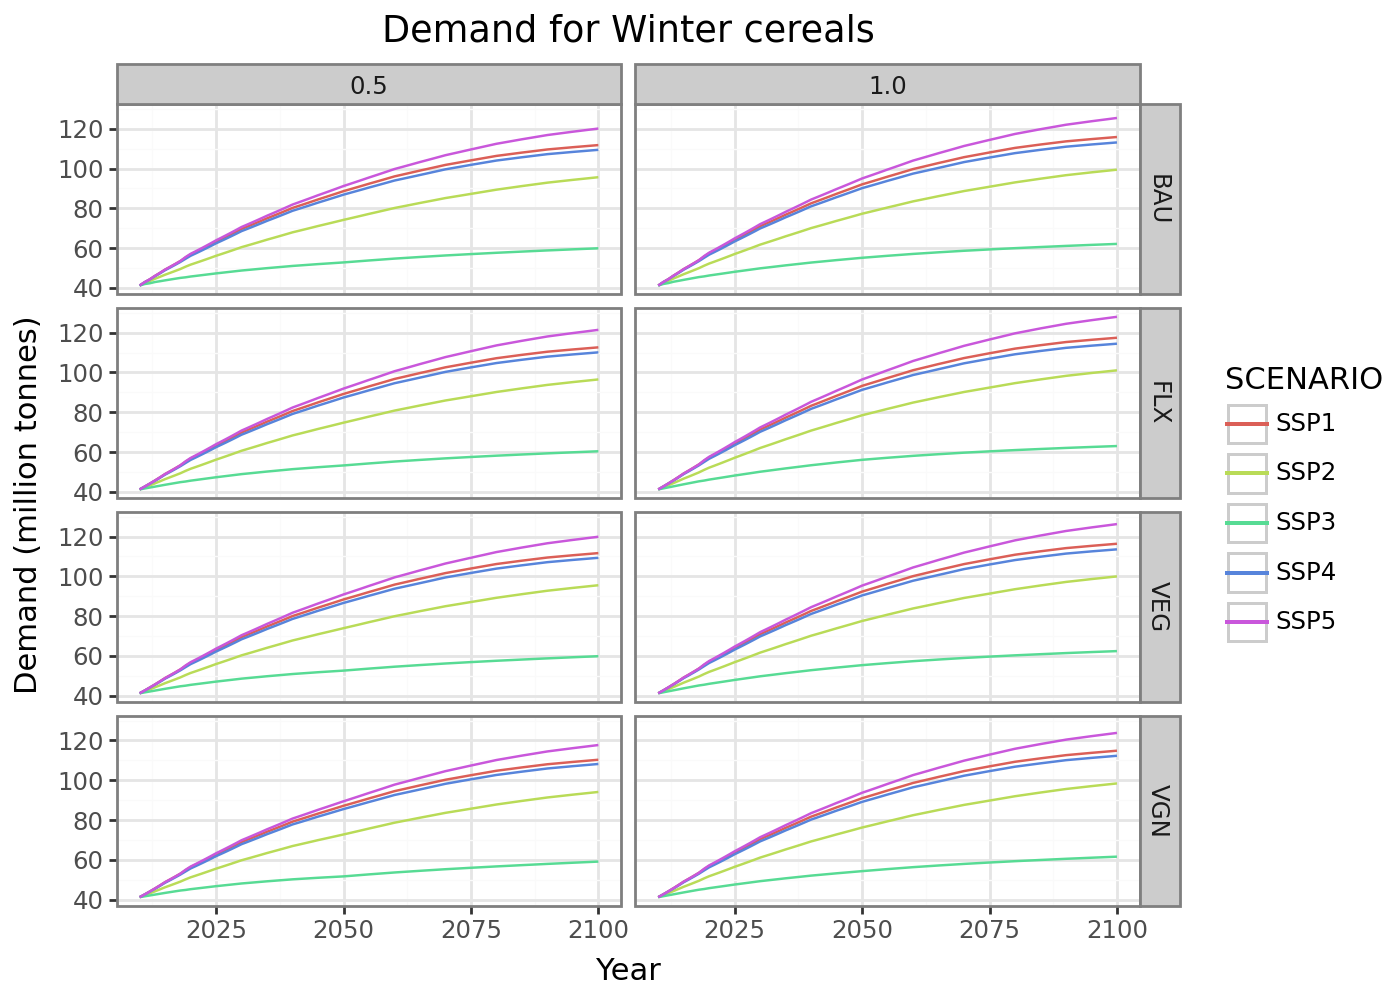

In [100]:
# HIDE CODE


# Get all demand 
dd = pd.read_hdf(os.path.join('input', 'demand_projections.h5') )
dd_long = dd['PRODUCTION'].stack().reset_index().rename(columns={0: 'DEMAND_TONNES'})

# Filter the demand data
commodity = lu_desc.lower()
diet_glob = 'BAU'
conv = 2050
import_t = 'Static'
feed_ef = 'BAU'
d = dd_long.query('COMMODITY == @commodity and DIET_GLOB == @diet_glob and CONVERGENCE == @conv and IMPORT_TREND == @import_t and FEED_EFFICIENCY == @feed_ef')


# Plot the demand under Diet~Waste scenarios
p9.options.figure_size = (7, 5)
p9.options.dpi = 100

fig = (p9.ggplot(d, p9.aes(x='YEAR', y='DEMAND_TONNES', color='SCENARIO'))
     + p9.geom_line()
     + p9.theme_bw()
     + p9.labs(title=f'Demand for {lu_desc}', x='Year', y='Demand (million tonnes)')
     + p9.scale_y_continuous(labels=lambda f: [f'{x / 1e6:.0f}' for x in f])
     + p9.facet_grid('DIET_DOM~WASTE')
    )

fig

OK, now that we know that LUTO needs to produce 77.31 million tonnes of winter cereal in 2050, let's see how it will arrange the spatial distributions to meet this goal.